In [2]:
import os, sys
sys.path.append(os.path.abspath(".."))

from src.earth.earth import EARTH

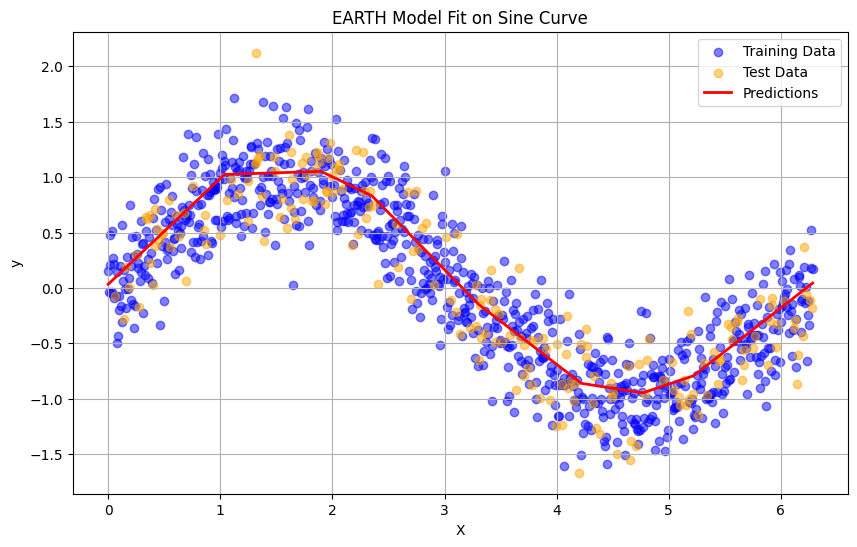

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Generate Sine Curve Data
def generate_sine_data(n_samples=200, noise_level=0.1, random_state=42):
    np.random.seed(random_state)
    X = np.linspace(0, 2 * np.pi, n_samples)
    y = np.sin(X) + noise_level * np.random.randn(n_samples)  # Sine curve with noise
    return X.reshape(-1, 1), y  # Reshape for sklearn compatibility

# Step 2: Split Data
X, y = generate_sine_data(n_samples=2000, noise_level=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 3: Fit the EARTH Model
earth_model = EARTH(M_max=15)
earth_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred = earth_model.predict(X)

# Step 5: Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)
plt.scatter(X_test, y_test, color='orange', label='Test Data', alpha=0.5)
plt.plot(X, y_pred, color='red', label='Predictions', linewidth=2)
plt.title('EARTH Model Fit on Sine Curve')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

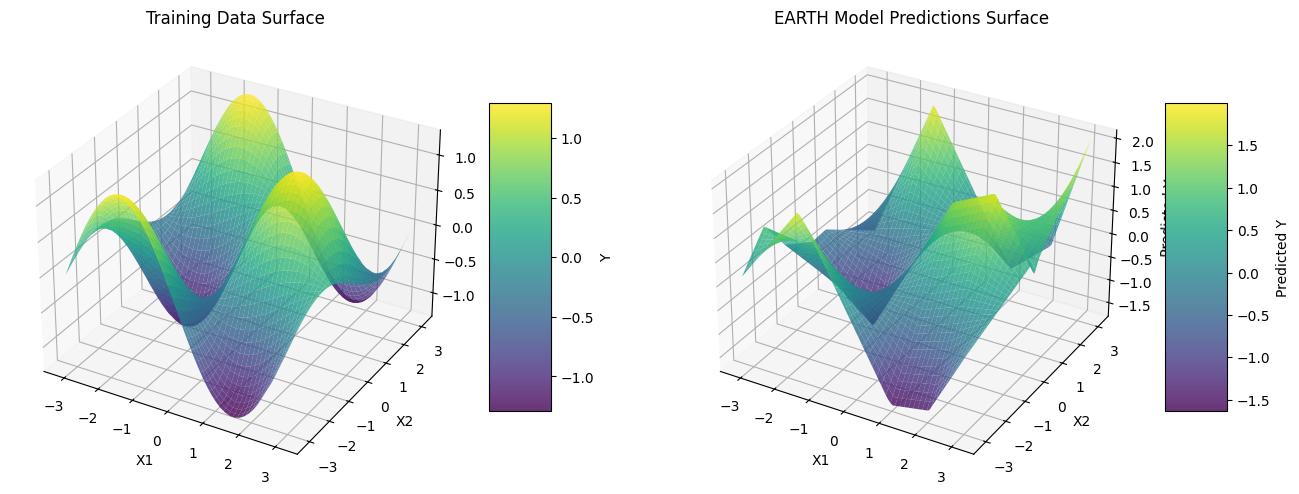

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

# Assume EARTH class is defined and imported from your module

# Step 1: Generate Intermediate Sine Data with Noise
def generate_intermediate_sine_data_with_noise(n_samples=40, noise_level=0.1, random_state=42):
    np.random.seed(random_state)
    X1 = np.linspace(-np.pi, np.pi, n_samples)
    X2 = np.linspace(-np.pi, np.pi, n_samples)
    X1, X2 = np.meshgrid(X1, X2)  # Create meshgrid
    Y = np.sin(X1) * np.cos(X2) + 0.3 * np.sin(X1 + X2)  # Target variable

    noise = noise_level * np.random.randn(*Y.shape)  # Add noise
    Y_noisy = Y + noise

    # Flatten the arrays for training
    df = pd.DataFrame({'X1': X1.ravel(), 'X2': X2.ravel(), 'Y': Y_noisy.ravel()})
    return df

# Generate the data
data = generate_intermediate_sine_data_with_noise(n_samples=50, noise_level=0.0)
X = data[['X1', 'X2']].values
y = data['Y'].values

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 3: Fit the EARTH Model
earth_model = EARTH(M_max=25)
earth_model.fit(X_train, y_train)

# Step 4: Create a grid for prediction
X1_grid, X2_grid = np.meshgrid(np.linspace(-np.pi, np.pi, 100), np.linspace(-np.pi, np.pi, 100))
X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])  # Combine into a 2D array

# Make Predictions
y_pred = earth_model.predict(X_grid).reshape(X1_grid.shape)  # Reshape to match grid shape

# Step 5: Create side-by-side surface plots for training data and predictions
fig = plt.figure(figsize=(16, 8))

# Training Data Surface Plot
ax1 = fig.add_subplot(121, projection='3d')
# Interpolate training data for a smooth surface
grid_y_train = griddata((X_train[:, 0], X_train[:, 1]), y_train, (X1_grid, X2_grid), method='linear')
surf_train = ax1.plot_surface(X1_grid, X2_grid, grid_y_train, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')
ax1.set_title('Training Data Surface')
fig.colorbar(surf_train, ax=ax1, shrink=0.5, aspect=5, label='Y')

# Predictions Surface Plot
ax2 = fig.add_subplot(122, projection='3d')
surf_pred = ax2.plot_surface(X1_grid, X2_grid, y_pred, cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Predicted Y')
ax2.set_title('EARTH Model Predictions Surface')
fig.colorbar(surf_pred, ax=ax2, shrink=0.5, aspect=5, label='Predicted Y')

plt.show()


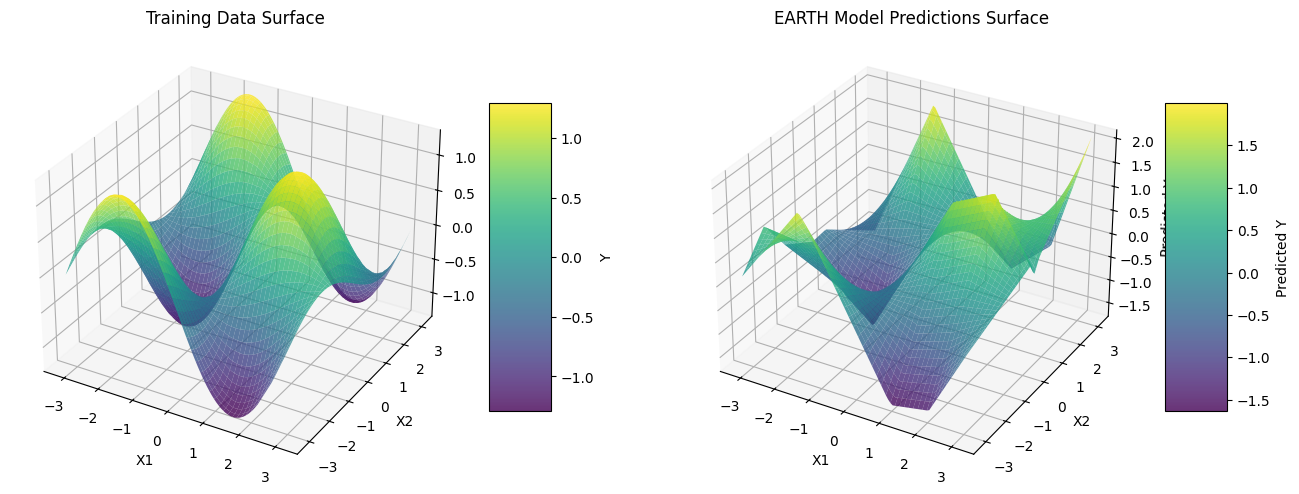